# Market segmentation
#### 08/11/2024

#### <span style="color:#1F618D">Consider the data in social_marketing.csv. This was data collected in the course of a market-research study using followers of the Twitter account of a large consumer brand that shall remain nameless---let's call it "NutrientH20" just to have a label. The goal here was for NutrientH20 to understand its social-media audience a little bit better, so that it could hone its messaging a little more sharply.</span>

#### <span style="color:#1F618D">A bit of background on the data collection: the advertising firm who runs NutrientH20's online-advertising campaigns took a sample of the brand's Twitter followers. They collected every Twitter post ("tweet") by each of those followers over a seven-day period in June 2014. Every post was examined by a human annotator contracted through Amazon's Mechanical Turk service. Each tweet was categorized based on its content using a pre-specified scheme of 36 different categories, each representing a broad area of interest (e.g. politics, sports, family, etc.) Annotators were allowed to classify a post as belonging to more than one category. For example, a hypothetical post such as "I'm really excited to see grandpa go wreck shop in his geriatic soccer league this Sunday!" might be categorized as both "family" and "sports." You get the picture.</span>

#### <span style="color:#1F618D">Each row of social_marketing.csv represents one user, labeled by a random (anonymous, unique) 9-digit alphanumeric code. Each column represents an interest, which are labeled along the top of the data file. The entries are the number of posts by a given user that fell into the given category. Two interests of note here are "spam" (i.e. unsolicited advertising) and "adult" (posts that are pornographic, salacious, or explicitly sexual). There are a lot of spam and pornography "bots" on Twitter; while these have been filtered out of the data set to some extent, there will certainly be some that slip through. There's also an "uncategorized" label. Annotators were told to use this sparingly, but it's there to capture posts that don't fit at all into any of the listed interest categories. (A lot of annotators may used the "chatter" category for this as well.) Keep in mind as you examine the data that you cannot expect perfect annotations of all posts. Some annotators might have simply been asleep at the wheel some, or even all, of the time! Thus there is some inevitable error and noisiness in the annotation process.</span>

#### <span style="color:#1F618D">Your task to is analyze this data as you see fit, and to prepare a concise report for NutrientH20 that identifies any interesting market segments that appear to stand out in their social-media audience. You have complete freedom in deciding how to pre-process the data and how to define "market segment." (Is it a group of correlated interests? A cluster? A latent factor? Etc.) Just use the data to come up with some interesting, well-supported insights about the audience, and be clear about what you did.</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

from sklearn.preprocessing import StandardScaler # to standardize the data for kmeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

Populating the interactive namespace from numpy and matplotlib


### Set up the dataset

In [2]:
market = pd.read_csv('social_marketing.csv', index_col = 0)
market.head()

,chatter,current_events,travel,photo_sharing,uncategorized,tv_film,sports_fandom,politics,food,family,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
hmjoe4g3k,2,0,2,2,2,1,1,0,4,1,...,1,0,1,1,0,11,0,0,0,0
clk1m5w8s,3,3,2,1,1,1,4,1,2,2,...,0,0,0,1,4,0,0,0,0,0
jcsovtak3,6,3,4,3,1,5,0,2,1,1,...,0,1,0,1,0,0,1,0,0,0
3oeb4hiln,1,5,2,2,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
fd75x1vgk,5,2,0,6,1,0,0,2,0,1,...,0,0,0,0,0,0,0,1,0,0


In [3]:
# Standardize the data for clustering
standardized = StandardScaler().fit_transform(market)

#### Before I start the clustering process, I would like to examine the features can look at their correlations with each other.

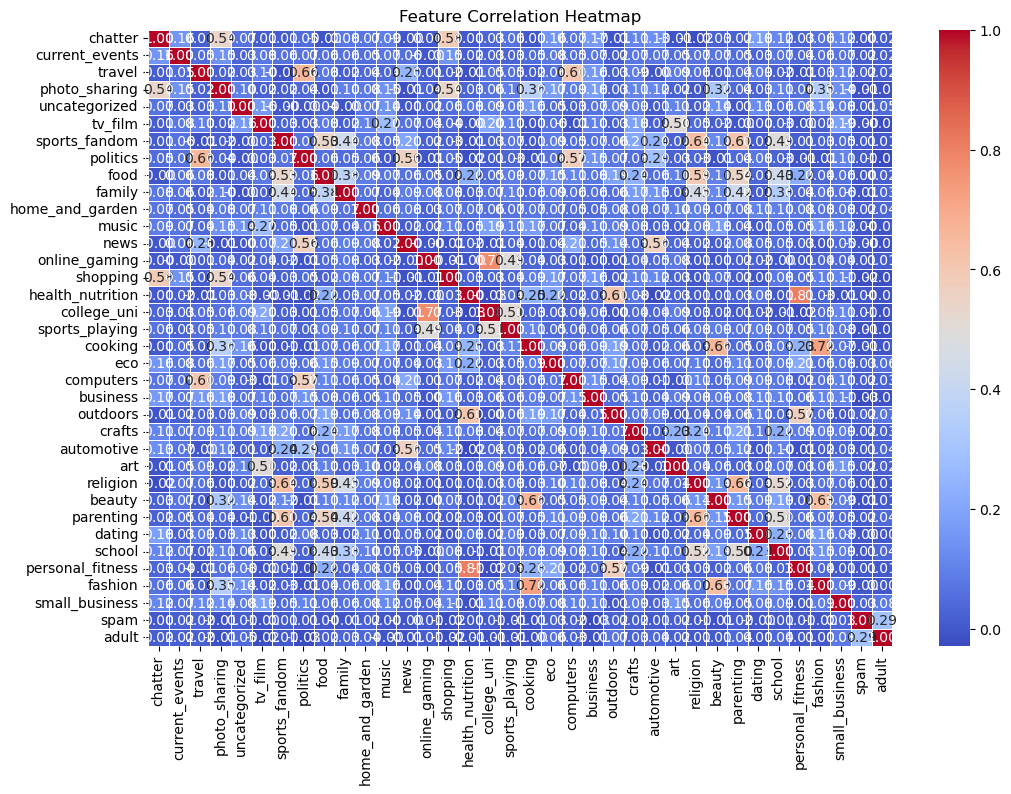

In [4]:
correlation_matrix = market.corr(numeric_only=True)  # To silence the future warning

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


#### It seems that most of the features have some kind of correlations with the other features. Since it is hard to see which features have the highest correlations, I printed the top five pairs of features with the highest correlations:

In [5]:
corr_pairs = correlation_matrix.unstack()
sorted_corr_pairs = corr_pairs.abs().sort_values(ascending=False)
high_corr_pairs = sorted_corr_pairs[(sorted_corr_pairs < 1.0) & (sorted_corr_pairs > 0.5)]
print('The top 10 pairs of closely related features are:')
print(high_corr_pairs.drop_duplicates()[:10])

The top 10 pairs of closely related features are:
health_nutrition  personal_fitness    0.809902
college_uni       online_gaming       0.772839
fashion           cooking             0.721403
beauty            cooking             0.664239
travel            politics            0.660210
parenting         religion            0.655597
religion          sports_fandom       0.637975
fashion           beauty              0.634974
outdoors          health_nutrition    0.608225
parenting         sports_fandom       0.607718
dtype: float64


#### Based on this list of feature pairs, we can identify some observable market segments. Users who are interested in both personal fitness and health nutrition are likely part of a segment consisting of fitness enthusiasts. Users interested in online gaming and college/university content are likely to be college students. Those who are interested in cooking may also show an interest in fashion and beauty, while users who are passionate about travel appear to have a strong interest in politics as well.

#### However, some of the market segments may not be identified through this correlation analysis, specially users with multiple interests. Thus, I would like to perform a clustering algorithm on the dataset.

#### Since we are looking for discrete market segments, we want to use the K-means clustering method.

#### To choose the number of clusters, I would like to plot an elbow plot.

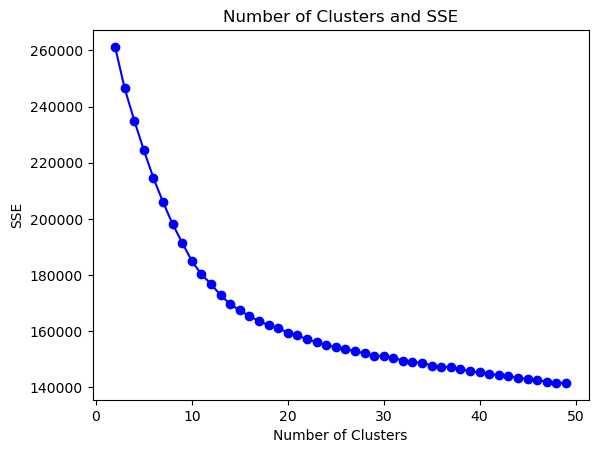

In [6]:
sse = []
for i in range(2, 50):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(standardized)
    sse.append(kmeans.inertia_)
    
plt.plot(range(2, 50), sse, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Number of Clusters and SSE')
plt.show()

#### To ensure that the result is interpretable, I chose 11 as the number of clusters. 11 clusters is a reasonable choice because the decrease in SSE slows down when the number of clusters further increases.

#### Reduce the feature dimensionality using PCA and tSNE, run a K-means clustering, and plot the clustering results:

In [7]:
scaler = StandardScaler()
market_scaled = scaler.fit_transform(market)

# Performing PCA
pca = PCA()
pca_market_segmentation_result = pca.fit_transform(market_scaled)

# Variance explained by each component
variance_explained = pca.explained_variance_
percentage_variance_explained = variance_explained / np.sum(variance_explained) * 100
cumulative_percentage_variance_explained = np.cumsum(percentage_variance_explained)

# Print cumulative percentage of variance explained
print(cumulative_percentage_variance_explained)

# Picking the number of components to explain 95% of the variance
components_needed = np.sum(cumulative_percentage_variance_explained < 95)
print(f"Number of components explaining 95% of variance: {components_needed}")

# Use the first 28 components as determined earlier
pca_market_segmentation = pca_market_segmentation_result[:, :28]

# Performing t-SNE on the reduced data
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_market_segmentation)

[ 12.46787753  20.47904529  27.5358883   34.07731532  40.16401898
  45.36890465  49.96117175  53.91313111  57.59486652  60.77100699
  63.58029076  66.18233051  68.74930848  71.22497269  73.64283656
  75.97854838  78.23866802  80.2868421   82.22198842  84.02401638
  85.59948891  86.94632136  88.25194915  89.43704262  90.60634825
  91.73545632  92.85996644  93.91105079  94.91662884  95.89752748
  96.85411723  97.69367874  98.34553094  98.97428394  99.50613637
 100.        ]
Number of components explaining 95% of variance: 29


/Users/eva/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/eva/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


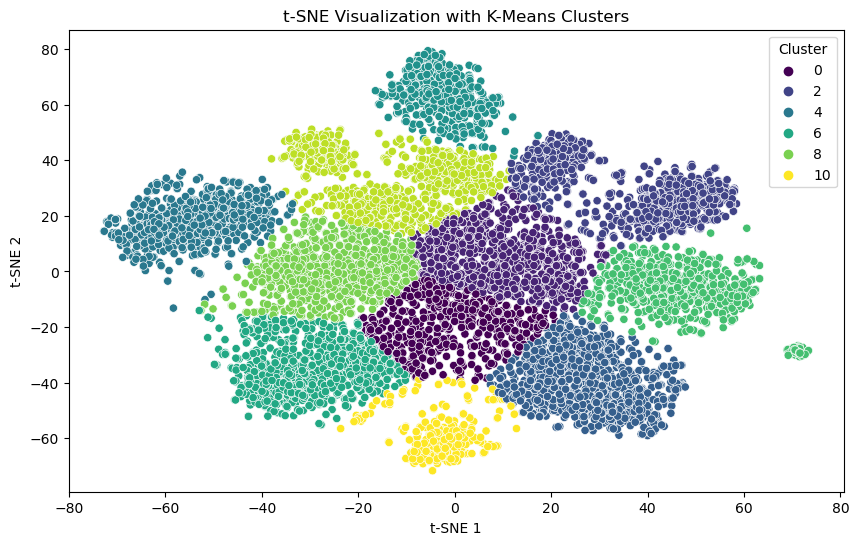

In [8]:
tsne_data = pd.DataFrame({
    'TSNE_1': tsne_result[:, 0],
    'TSNE_2': tsne_result[:, 1]
})
kmeans = KMeans(n_clusters=11, random_state=42)
tsne_data['Cluster'] = kmeans.fit_predict(tsne_data[['TSNE_1', 'TSNE_2']])

# Plotting the clustered t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Cluster', data=tsne_data, palette='viridis')
plt.title("t-SNE Visualization with K-Means Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title='Cluster')
plt.show()

#### As shown in the graph above, K-means clustering is good job clustering the users based on the tSNE features

#### Since this dataset does not have too much features, to ensure the interpretability of the clustering result and identify the interests of each user cluster, we want to run K-means clustering again without any dimensionality reduction methods.

In [9]:
# K-means clustering with 11 clusters
kmeans_11 = KMeans(n_clusters=11, random_state=1)
kmeans_label = kmeans_11.fit(standardized)
market['cluster'] = kmeans_11.fit_predict(standardized)

#### To evaluate the performance of k-means clustering and look at whether k-means clustering is successfully differentiating users in different market segments, I would like to graph some scatter plots on features with high popularity and correlation.

In [10]:
corr_pairs = correlation_matrix.unstack()
sorted_corr_pairs = corr_pairs.abs().sort_values(ascending=False)
high_corr_pairs = sorted_corr_pairs[(sorted_corr_pairs < 1.0) & (sorted_corr_pairs > 0.5)]
print('The top 10 pairs of closely related features are:')
print(high_corr_pairs.drop_duplicates()[:10])

The top 10 pairs of closely related features are:
health_nutrition  personal_fitness    0.809902
college_uni       online_gaming       0.772839
fashion           cooking             0.721403
beauty            cooking             0.664239
travel            politics            0.660210
parenting         religion            0.655597
religion          sports_fandom       0.637975
fashion           beauty              0.634974
outdoors          health_nutrition    0.608225
parenting         sports_fandom       0.607718
dtype: float64


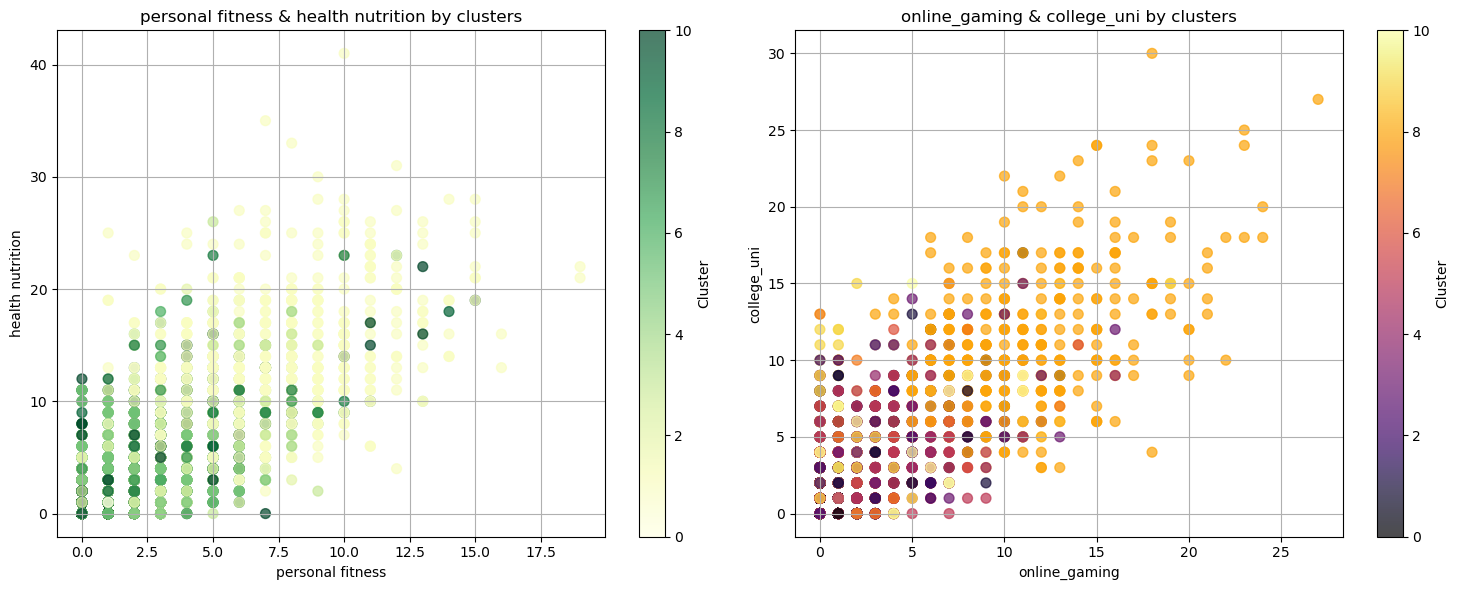

In [11]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for the first pair: personal_fitness & health_nutrition
scatter1 = axes[0].scatter(market['personal_fitness'], market['health_nutrition'], 
                           c=market['cluster'], cmap='YlGn', s=50, alpha=0.7)
axes[0].set_title('personal fitness & health nutrition by clusters')
axes[0].set_xlabel('personal fitness')
axes[0].set_ylabel('health nutrition')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True)

# Scatter plot for the second pair: online_gaming & college_uni
scatter2 = axes[1].scatter(market['online_gaming'], market['college_uni'],
                           c=market['cluster'], cmap='inferno', s=50, alpha=0.7)
axes[1].set_title('online_gaming & college_uni by clusters')
axes[1].set_xlabel('online_gaming')
axes[1].set_ylabel('college_uni')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True)

plt.tight_layout()
plt.show()


#### As shown in the scatter plot above, there is a strong linear relationship between health_nutrition and personal_fitness and online gaming and college_uni. The clusters are also able to differentiate users that are passionate in these two pairs of topics from users with less passion.

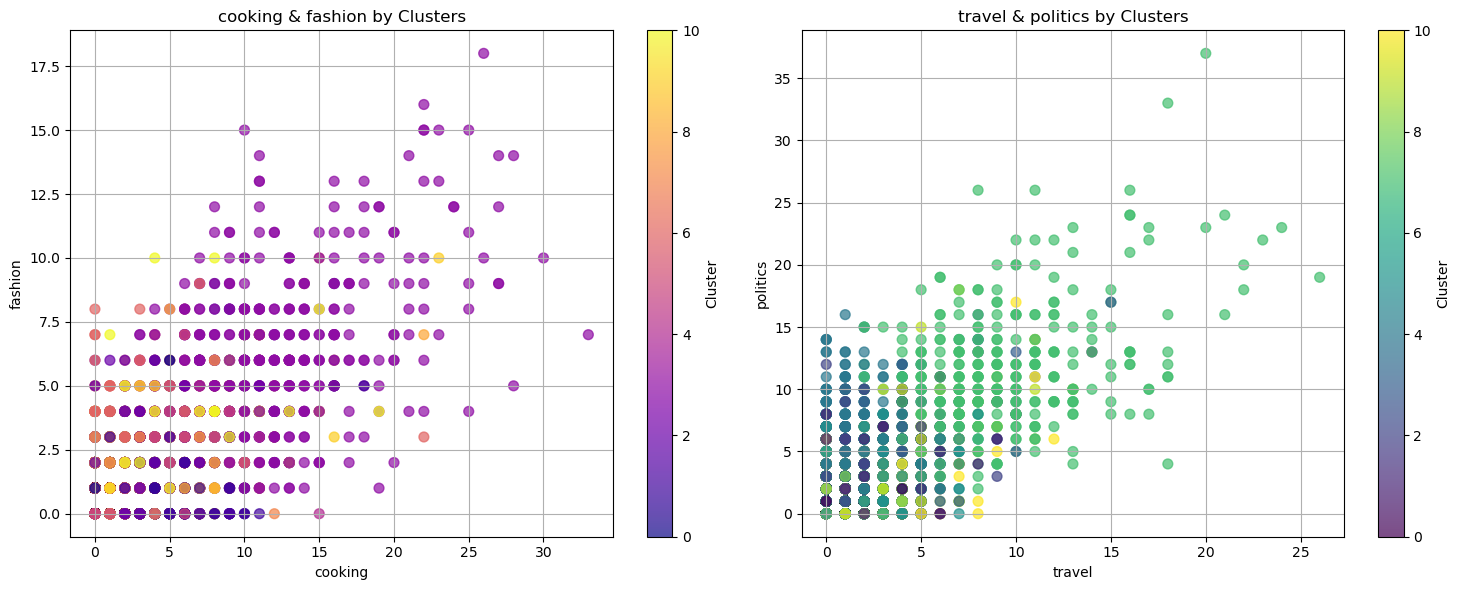

In [12]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for the first pair: cooking & fashion
scatter1 = axes[0].scatter(market['cooking'], market['fashion'], 
                           c=market['cluster'], cmap='plasma', s=50, alpha=0.7)
axes[0].set_title('cooking & fashion by Clusters')
axes[0].set_xlabel('cooking')
axes[0].set_ylabel('fashion')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True)

# Scatter plot for the second pair: travel & politics
scatter2 = axes[1].scatter(market['travel'], market['politics'],
                           c=market['cluster'], cmap='viridis', s=50, alpha=0.7)
axes[1].set_title('travel & politics by Clusters')
axes[1].set_xlabel('travel')
axes[1].set_ylabel('politics')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')
axes[1].grid(True)

plt.tight_layout()
plt.show()


#### Cooking & fashion and travel & politics are also demonstrating strong positive relationships. Whether clustering is also good identifying users interested in travel & politics, it is not doing that well identifying users interested in cooking & fashion. <br><br><br>

In [13]:
# Get the center of each cluster
centers_df = pd.DataFrame(kmeans_11.cluster_centers_, columns=market.columns[:-1])
centers_df

,chatter,current_events,travel,photo_sharing,uncategorized,tv_film,sports_fandom,politics,food,family,...,religion,beauty,parenting,dating,school,personal_fitness,fashion,small_business,spam,adult
0,0.072063,0.276865,0.288745,-0.090724,0.112606,-0.116198,0.140666,0.150537,0.040497,-0.059999,...,0.120709,-0.100708,0.186596,-0.009529,0.092454,0.121840,-0.020451,0.314308,12.419652,3.750460
1,-0.177726,-0.027502,-0.159515,-0.131606,0.147331,-0.153666,-0.191320,-0.204550,0.462029,-0.081490,...,-0.161497,-0.210011,-0.092699,0.041521,-0.201270,2.151293,-0.128147,-0.135918,-0.077692,0.021456
2,1.507762,0.365975,-0.210349,1.200980,-0.015220,-0.135418,-0.194798,-0.132901,-0.304931,-0.038164,...,-0.281829,-0.227144,-0.206839,-0.153710,-0.042321,-0.164372,-0.153259,0.149222,-0.077692,-0.037256
3,-0.067094,0.172507,-0.057513,1.244173,0.513729,-0.140035,-0.211934,-0.135491,-0.205633,0.028664,...,-0.124278,2.657073,-0.060693,-0.051054,0.128253,-0.044844,2.740204,0.168690,-0.077692,0.003884
4,-0.077576,0.074101,-0.184769,-0.217111,-0.100078,-0.011093,0.673607,1.227614,-0.154804,0.230583,...,-0.180397,-0.175817,0.037904,-0.083906,-0.001001,-0.226442,-0.226455,-0.158756,-0.077692,-0.107966
5,-0.374594,-0.204934,-0.217411,-0.421361,-0.181133,-0.221459,-0.321764,-0.299337,-0.358893,-0.302852,...,-0.299258,-0.272672,-0.322846,-0.218844,-0.329894,-0.336547,-0.298878,-0.210110,-0.077692,-0.010007
6,0.968850,0.062775,-0.064138,-0.036875,0.747305,-0.075044,-0.163197,-0.165929,-0.157291,-0.123382,...,-0.000946,0.251735,0.068167,4.695207,1.236134,-0.034408,0.785936,0.348464,-0.077692,-0.056709
7,-0.093996,0.111424,3.296832,-0.118477,-0.093016,-0.059952,-0.206094,3.138207,0.166938,-0.085743,...,0.123755,-0.188535,0.017279,0.235847,-0.118564,-0.152117,-0.179914,0.385059,-0.077692,-0.146857
8,-0.097570,-0.085059,-0.036568,-0.015920,-0.048177,0.099278,-0.133017,-0.177003,-0.093158,0.206231,...,-0.189002,-0.235424,-0.137186,-0.043553,-0.228918,-0.179015,-0.082756,0.104853,-0.077692,-0.020163
9,-0.131936,0.330453,0.222744,-0.082919,0.673308,2.755690,-0.116822,-0.087063,0.141388,-0.109288,...,0.010931,0.009543,-0.202921,-0.144700,-0.048227,-0.153011,-0.045511,0.797389,-0.077692,-0.036778


#### The cluster centers can give me a good summary of the general preferences of each cluster. The center of Cluster 1 have high values in both spam and adult, suggesting that Twitter may want to pay extra attention to the posts of this group of users and potentially filter their posts.

#### To further examine the posts of users in each cluster, I would like to plot the average value of each feature in each cluster.

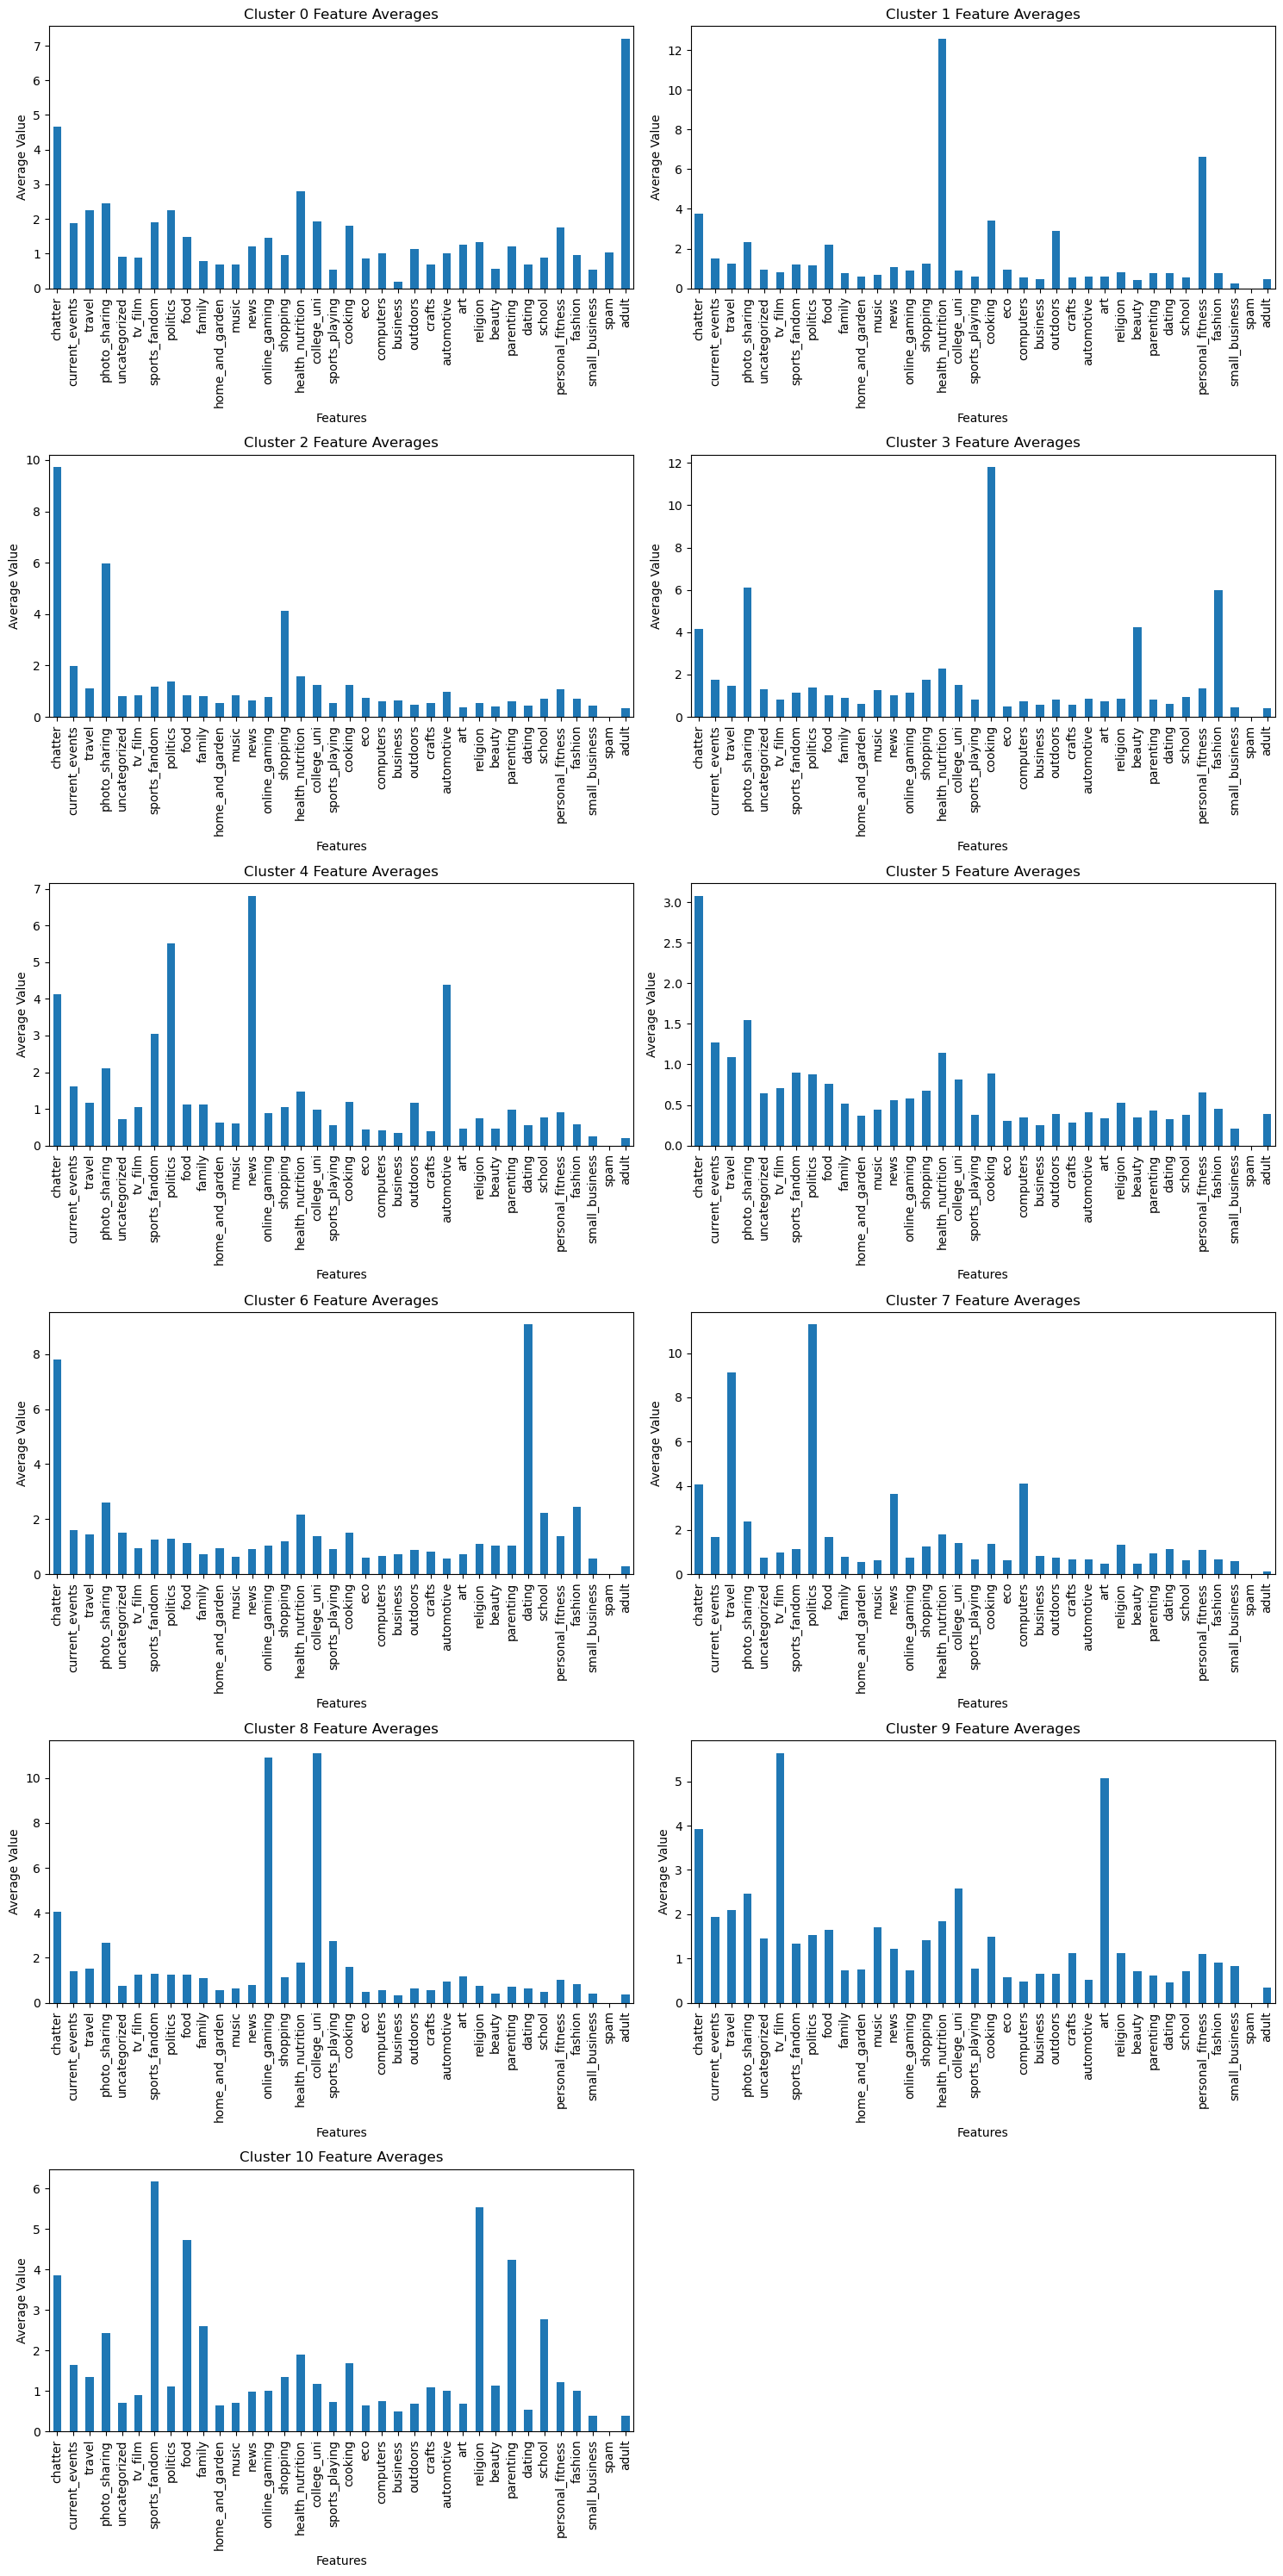

In [14]:
clusters = sort(market['cluster'].unique())
num_clusters = len(clusters)

num_cols = 2
num_rows = (num_clusters + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for ax, cluster in zip(axes.flat, clusters):
    cluster_data = market[market['cluster'] == cluster]
    means = cluster_data.drop(columns='cluster').mean()

    means.plot(kind='bar', ax=ax)

    ax.set_title(f'Cluster {cluster} Feature Averages')
    ax.set_xlabel('Features')
    ax.set_ylabel('Average Value')
    ax.set_xticklabels(means.index.values, rotation=90)

# Hide empty subplots
for ax in axes.flat[num_clusters:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### Based on the plot, the list below details the collective interests of users in each cluster. Twitter can use this information to provide target recommendations and ads.

&emsp; Cluster 0: This group have a remarkable high average value in adult compared to other topics, which supports my statement above. However, while the cluster center has a value of 12.42 in spam, the average spam value of the users in this cluster is 1. While this value is still higher than the average spam values of other clusters, most users in this cluster may not be posting spam contents.<br>
&emsp; Cluster 1: This group is huge on health_nutrition and personal_fitness, which makes sense given that health_nutrion and personal_fitness are highly correlated.<br>
&emsp; Cluster 2: This group of users enjoy posting contents about random topics(chatter), photos, and shopping. This group is likely to consist more female users than male users.<br>
&emsp; Cluster 3: Biggest on cooking, fashion, beauty, and photo-sharing. This is very likely a female-dominated group who are interested in cooking recipes and beauty products.<br>
&emsp; Cluster 4: Biggest on news, politics, and automotive. This group of users is likely to be male-dominated and use twitter as one of their news sources. They are also interested in random topics(chatter), photo-sharing, and sports.<br>
&emsp; Cluster 5: This group of users enjoy posting contents on random topics(chatters). However, they are not very passionate about the other topics. Thus, it may be particularly difficult for Twitter to target them in advertisements.<br>
&emsp; Cluster 6: Biggest on dating and random topics(chatter) and do not care very much toward the other topics. This group of users may use Twitter as a dating/networking app.<br>
&emsp; Cluster 7: This group has large interests in politics and travel. However, unlike Cluster 4, they do not seem to use Twitter as a news source. They are also interested in travel and computers. <br>
&emsp; Cluster 8: This group is likely made up of college students, given that they are very passionate about college/university contents and online-gaming. This market segment is also identified in the feature correlation analysis.<br>
&emsp; Cluster 9: This group is likely to be consisted of artists and film makers since they have huge interests in art, TV, and film. They also appear to like posting about random topics (chatter). <br>
&emsp; Cluster 10: This group have very diverse interests, ranging from sports, foods, to religion and family. GIven their interests in parenting contents, they are very likely to have children. <br><br><br>